# 0.Import Libraries

In [1]:
import os

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from transformers import BeitImageProcessor, AutoModel
import torch
from IPython.display import Image as IPython_Image
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist

2024-07-09 08:43:51.677403: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 08:43:51.677517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 08:43:51.835653: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1.Getting Data List

In [2]:
input_path = '/kaggle/input/chest-ctscan-images/Data/'
train_path = [input_path + 'train/' +s for s in os.listdir(input_path + 'train')]
test_path = [input_path + 'test/' + s for s in os.listdir(input_path + 'test')]
valid_path = [input_path + 'valid/' + s for s in os.listdir(input_path + 'valid')]

In [3]:
train_path

['/kaggle/input/chest-ctscan-images/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa',
 '/kaggle/input/chest-ctscan-images/Data/train/normal',
 '/kaggle/input/chest-ctscan-images/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
 '/kaggle/input/chest-ctscan-images/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib']

# 2.Plotting Example Images

/kaggle/input/chest-ctscan-images/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000037 (2).png


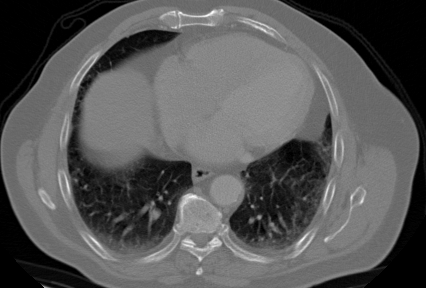

In [4]:
print(train_path[0] + '/' + os.listdir(train_path[0])[0])
IPython_Image(train_path[0] + '/' + os.listdir(train_path[0])[0])

/kaggle/input/chest-ctscan-images/Data/train/normal/16 - Copy (2) - Copy.png


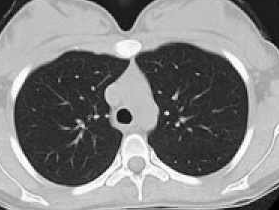

In [5]:
print(train_path[1] + '/' + os.listdir(train_path[1])[0])
IPython_Image(train_path[1] + '/' + os.listdir(train_path[1])[0])

/kaggle/input/chest-ctscan-images/Data/train/normal/11 - Copy.png


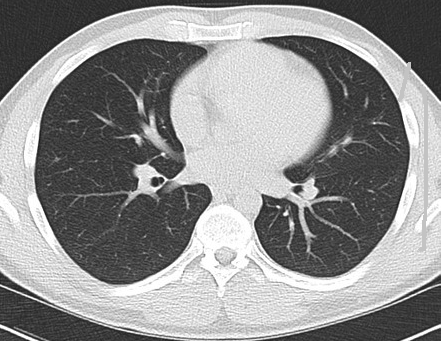

In [6]:
print(train_path[1] + '/' + os.listdir(train_path[1])[1])
IPython_Image(train_path[1] + '/' + os.listdir(train_path[1])[1])

/kaggle/input/chest-ctscan-images/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000078 (3).png


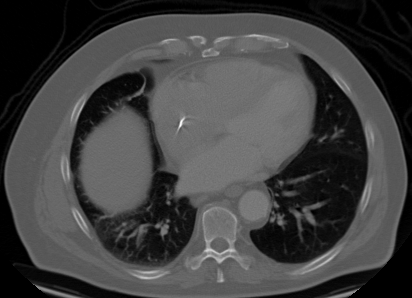

In [7]:
print(train_path[2] + '/' + os.listdir(train_path[2])[0])
IPython_Image(train_path[2] + '/' + os.listdir(train_path[2])[0])

/kaggle/input/chest-ctscan-images/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000015 (10).png


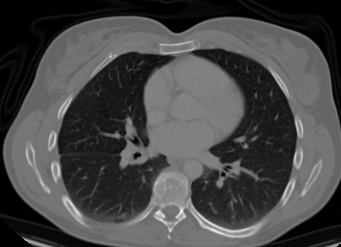

In [8]:
print(train_path[3] + '/' + os.listdir(train_path[3])[0])
IPython_Image(train_path[3] + '/' + os.listdir(train_path[3])[0])

/kaggle/input/chest-ctscan-images/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000083 (6).png


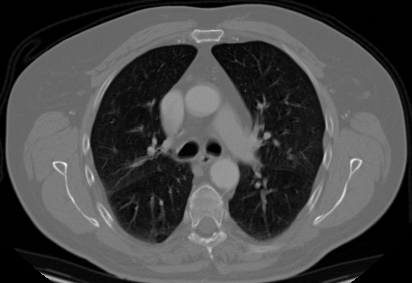

In [9]:
print(train_path[3] + '/' + os.listdir(train_path[3])[1])
IPython_Image(train_path[3] + '/' + os.listdir(train_path[3])[1])

# 3.Defining the Dit-Base Model

In [10]:
processor = BeitImageProcessor.from_pretrained("microsoft/dit-base")
model = AutoModel.from_pretrained("microsoft/dit-base")

preprocessor_config.json:   0%|          | 0.00/302 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BeitModel were not initialized from the model checkpoint at microsoft/dit-base and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 3.Getting Embeddings of a Sample Image

In [11]:
image = Image.open(train_path[0] + '/000003.png').convert('RGB')

num_patches = (model.config.image_size // model.config.patch_size) ** 2
pixel_values = processor(images=image, return_tensors="pt").pixel_values
# create random boolean mask of shape (batch_size, num_patches)
bool_masked_pos = torch.randint(low=0, high=2, size=(1, num_patches)).bool()

outputs = model(pixel_values, bool_masked_pos=bool_masked_pos)
outputs.pooler_output.shape

torch.Size([1, 768])

In [12]:
outputs.last_hidden_state.shape

torch.Size([1, 197, 768])

# 4.Getting Similarities Between Normal Images

In [13]:
model.cuda()

BeitModel(
  (embeddings): BeitEmbeddings(
    (patch_embeddings): BeitPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BeitEncoder(
    (layer): ModuleList(
      (0): BeitLayer(
        (attention): BeitAttention(
          (attention): BeitSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=False)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): BeitSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): BeitIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivatio

In [14]:
dictionary_normal = pd.DataFrame(columns=['image_1','image_2','similarity','distance'])

file_list = [train_path[1] + '/' +s for s in os.listdir(train_path[1])]

for y in range(len(file_list)):
    a = y + 1
    while(a < len(file_list)):
        image1 = Image.open(file_list[y]).convert('RGB')
        image2 = Image.open(file_list[a]).convert('RGB')
                
        num_patches = (model.config.image_size // model.config.patch_size) ** 2
        pixel_values = processor(images=image1, return_tensors="pt").pixel_values
        pixel_values = pixel_values.cuda()
        outputs = model(pixel_values)
        outputs = outputs.pooler_output.cpu()       
                
        num_patches2 = (model.config.image_size // model.config.patch_size) ** 2
        pixel_values2 = processor(images=image2, return_tensors="pt").pixel_values
        pixel_values2 = pixel_values2.cuda()
        outputs2 = model(pixel_values2)
        outputs2 = outputs2.pooler_output.cpu()
        
        dictionary_normal = pd.concat([dictionary_normal, pd.DataFrame({'image_1': file_list[y],                                                                     
                                                                        'image_2': file_list[a], 
                                                                        'similarity':cosine_similarity(outputs.detach().numpy() , 
                                                                                                       outputs2.detach().numpy())[0][0], 
                                                                        'distance': cdist(outputs.detach().numpy() , 
                                                                                          outputs2.detach().numpy(),
                                                                                          metric='euclidean')[0][0]}, 
                                                                       index=[0])], ignore_index=True)
        
        a += 1 

In [15]:
len(file_list)

148

In [16]:
dictionary_normal.shape, 148*147/2

((10878, 4), 10878.0)

# 5.Plotting Results

In [17]:
plt.style.use('seaborn-darkgrid')

/tmp/ipykernel_35/448178554.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


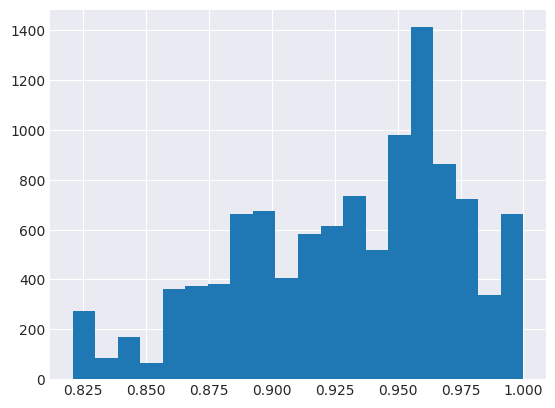

In [18]:
plt.hist(dictionary_normal['similarity'], bins=20)
plt.show()

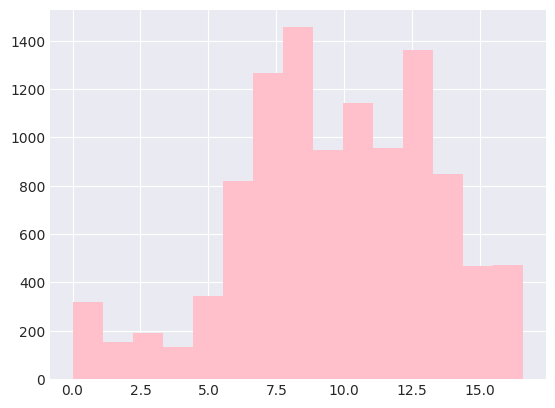

In [19]:
plt.hist(dictionary_normal['distance'], bins=15,color='pink')
plt.show()

In [20]:
dictionary_normal['below_simiilarity_mean'] = np.where(dictionary_normal['similarity'] > dictionary_normal['similarity'].mean(), 0, 1)

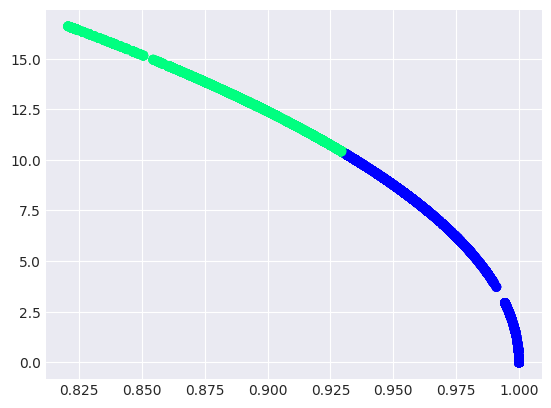

In [21]:
plt.scatter(dictionary_normal['similarity'], dictionary_normal['distance'], c=dictionary_normal['below_simiilarity_mean'], cmap='winter')
plt.show()

In [22]:
model.cpu()
dictionary_normal_embeddings = {}

mean_embedding = torch.zeros([1, 768]), 
sum_tensor = torch.zeros([1, 768])

for y in range(len(file_list)):        
    image1 = Image.open(file_list[y]).convert('RGB')          
    num_patches = (model.config.image_size // model.config.patch_size) ** 2
    pixel_values = processor(images=image1, return_tensors="pt").pixel_values
    outputs = model(pixel_values)
    outputs = outputs.pooler_output   
            
    dictionary_normal_embeddings[file_list[y]] = outputs.detach().numpy()
    sum_tensor += outputs      

mean_embedding = sum_tensor/148

In [23]:
mean_embedding

tensor([[-6.6311e-01,  5.5696e-01,  3.0347e-01, -2.4861e-01, -1.4009e-01,
         -1.0712e+00,  1.2295e-01,  6.4085e-01,  5.3513e-01, -1.3882e+00,
         -2.5779e-01,  4.8242e-01,  1.0418e+00, -6.7419e-02, -6.1984e-01,
          2.7500e-01,  7.9272e-01, -3.0230e-01,  3.5783e-01,  2.3724e-01,
          2.1166e-02, -2.9247e-01, -3.5022e-01, -2.0023e-01,  3.8130e-01,
         -8.2920e-02,  3.9566e-02,  4.5682e-01,  6.6874e-01,  6.2211e-01,
          8.3205e-01, -4.5117e-01,  9.3575e-01, -2.1638e-01,  1.8984e-01,
          1.3796e-01, -6.4254e-02,  2.5320e-02,  6.4363e-01,  9.2833e-02,
         -1.8106e-01,  1.5928e-01, -6.7165e-01, -5.6844e-01, -8.1074e-02,
         -7.1257e-01,  5.5561e-02,  5.3588e-01,  6.1830e-01,  1.5037e+00,
         -3.0635e-01, -1.6813e-01, -1.4939e-01,  2.7628e-01, -5.3675e-02,
          1.4994e-01, -1.7125e-02, -6.7567e-02,  3.5645e-01, -3.0890e-01,
          7.3453e-01,  2.4088e-01, -2.6592e-01,  6.5422e-01, -1.9859e-01,
         -2.4740e-01,  5.9296e-02,  1.

In [24]:
normal_embeddings_mean_comp = pd.DataFrame(columns=['image_1','image_2','similarity','distance'])


for x in range(len(file_list)):
    image1 = Image.open(file_list[x]).convert('RGB')
            
    num_patches = (model.config.image_size // model.config.patch_size) ** 2
    pixel_values = processor(images=image1, return_tensors="pt").pixel_values
    outputs = model(pixel_values)
    
    normal_embeddings_mean_comp = pd.concat([normal_embeddings_mean_comp, pd.DataFrame({'image_1': file_list[x] ,
                                                                                       'image_2': "normal_mean_embedding",
                                                                                       'similarity':cosine_similarity(outputs.pooler_output.detach().numpy(),
                                                                                                                      mean_embedding.detach().numpy())[0][0],
                                                                                       'distance': cdist(outputs.pooler_output.detach().numpy() , 
                                                                                                         mean_embedding.detach().numpy(),
                                                                                                         metric='euclidean')[0][0]}, 
                                                                                      index=[0])], ignore_index=True)

In [25]:
normal_embeddings_mean_comp.head()

,image_1,image_2,similarity,distance
0,/kaggle/input/chest-ctscan-images/Data/train/n...,normal_mean_embedding,0.980427,5.472942
1,/kaggle/input/chest-ctscan-images/Data/train/n...,normal_mean_embedding,0.976222,6.015417
2,/kaggle/input/chest-ctscan-images/Data/train/n...,normal_mean_embedding,0.977563,5.847859
3,/kaggle/input/chest-ctscan-images/Data/train/n...,normal_mean_embedding,0.973012,6.398693
4,/kaggle/input/chest-ctscan-images/Data/train/n...,normal_mean_embedding,0.983394,5.055304


In [26]:
normal_embeddings_mean_comp.shape

(148, 4)

In [27]:
similarity_threshold = normal_embeddings_mean_comp['similarity'].mean() - (2 * normal_embeddings_mean_comp['similarity'].std())
distance_threshold = normal_embeddings_mean_comp['distance'].mean() + (2 * normal_embeddings_mean_comp['distance'].std())

In [28]:
normal_embeddings_mean_comp['below_similarity_mean'] = np.where(normal_embeddings_mean_comp['similarity'] > similarity_threshold, 0, 1)
normal_embeddings_mean_comp['below_distance_mean'] = np.where(normal_embeddings_mean_comp['distance'] > distance_threshold, 0, 1)

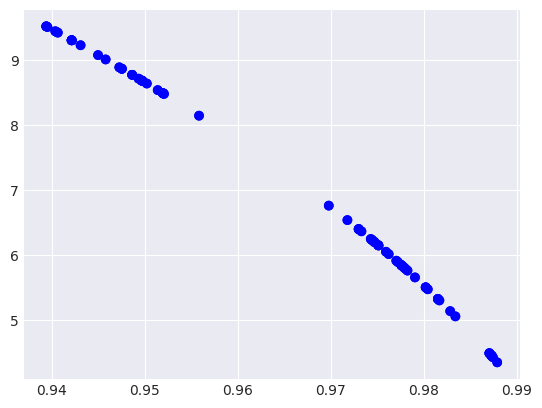

In [29]:
plt.scatter(normal_embeddings_mean_comp['similarity'], 
            normal_embeddings_mean_comp['distance'], 
            c= normal_embeddings_mean_comp['below_similarity_mean'], 
            cmap='winter')
plt.show()

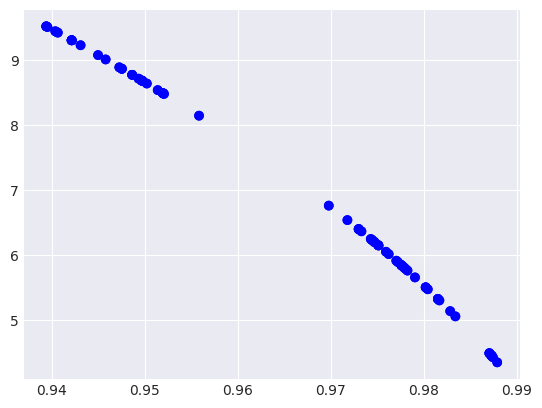

In [30]:
plt.scatter(normal_embeddings_mean_comp['similarity'], 
            normal_embeddings_mean_comp['distance'], 
            c= normal_embeddings_mean_comp['below_distance_mean'], 
            cmap='winter')
plt.show()

In [31]:
similarity_threshold

0.9316386952996254

In [32]:
train_path = [input_path + 'train/' +s for s in os.listdir(input_path + 'train')]
test_path = [input_path + 'test/' + s for s in os.listdir(input_path + 'test')]
valid_path = [input_path + 'valid/' + s for s in os.listdir(input_path + 'valid')]

In [33]:
final_list= [train_path, test_path, valid_path]
final_list

[['/kaggle/input/chest-ctscan-images/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa',
  '/kaggle/input/chest-ctscan-images/Data/train/normal',
  '/kaggle/input/chest-ctscan-images/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
  '/kaggle/input/chest-ctscan-images/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'],
 ['/kaggle/input/chest-ctscan-images/Data/test/squamous.cell.carcinoma',
  '/kaggle/input/chest-ctscan-images/Data/test/normal',
  '/kaggle/input/chest-ctscan-images/Data/test/adenocarcinoma',
  '/kaggle/input/chest-ctscan-images/Data/test/large.cell.carcinoma'],
 ['/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa',
  '/kaggle/input/chest-ctscan-images/Data/valid/normal',
  '/kaggle/input/chest-ctscan-images/Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
  '/kaggle/input/chest-ctscan-images/Data/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib']]

In [39]:
anomalies = pd.DataFrame(columns=['folder_name','image_name','threshold_type','threshold_distance','threshold_similarity','similarity','distance','similarity_flag','distance_flag'])

total = 0
for x in final_list:
    for y in x :
        file_list_y = os.listdir(y)
        for z in file_list_y:
            image1 = Image.open(y+'/'+z).convert('RGB')
            
            num_patches = (model.config.image_size // model.config.patch_size) ** 2
            pixel_values = processor(images=image1, return_tensors="pt").pixel_values
            outputs = model(pixel_values)
            
            similarity = cosine_similarity(outputs.pooler_output.detach().numpy() ,
                                           mean_embedding.detach().numpy())[0][0]
            distance = cdist(outputs.pooler_output.detach().numpy() , 
                             mean_embedding.detach().numpy(),
                             metric='euclidean')[0][0]

            if similarity < similarity_threshold:
                similarity_flag=1
            else: 
                similarity_flag=0

            if distance > distance_threshold:
                distance_flag=1
            else:
                distance_flag=0

            anomalies = pd.concat([anomalies,pd.DataFrame({'folder_name': y , 
                                                       'image_name':  z,
                                                       'threshold_type': "saha_similarity_threshold",
                                                       'threshold_distance': distance_threshold,
                                                       'threshold_similarity' : similarity_threshold,
                                                       'distance': distance,
                                                       'similarity': similarity,                                                       
                                                       'distance_flag': distance_flag,
                                                       'similarity_flag':similarity_flag} ,
                                                      index=[0])], ignore_index=True)


In [40]:
anomalies['folder_name'].replace(to_replace='/kaggle/input/chest-ctscan-images/Data/',value='',regex=True,inplace=True)
anomalies[['folder_type','class_name']] = anomalies['folder_name'].str.split('/',expand=True)
anomalies.drop('folder_name',inplace=True,axis=1)
anomalies['true_label'] = np.where(anomalies['class_name']=='normal', 0, 1)
anomalies['true_diagnose_distance'] =  np.where(anomalies['distance_flag']==anomalies['true_label'] , 1, 0)
anomalies['true_diagnose_similarity'] =  np.where(anomalies['similarity_flag']==anomalies['true_label'], 1, 0)
anomalies = pd.DataFrame(anomalies, columns=['folder_type', 
                                             'class_name',
                                             'image_name', 
                                             'threshold_type',
                                            'threshold_similarity',
                                            'threshold_distance',
                                            'similarity',
                                            'distance',
                                             'true_label',
                                            'similarity_flag',
                                            'distance_flag',
                                            'true_diagnose_similarity',
                                            'true_diagnose_distance'])

In [41]:
anomalies['true_diagnose_distance'].mean(), anomalies['true_diagnose_similarity'].mean()

(0.94, 0.953)

In [42]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
confusion_matrix(anomalies['true_label'], anomalies['true_diagnose_distance'])

array([[  1, 214],
       [ 59, 726]])

In [43]:
confusion_matrix(anomalies['true_label'], anomalies['true_diagnose_similarity'])

array([[  1, 214],
       [ 46, 739]])

In [44]:
precision_recall_fscore_support(anomalies['true_label'], anomalies['true_diagnose_similarity'], average='macro')

(0.3983612779352995, 0.473026218338024, 0.4290181747907132, None)

In [45]:
precision_recall_fscore_support(anomalies['true_label'], anomalies['true_diagnose_similarity'], average='micro')

(0.74, 0.74, 0.74, None)

In [46]:
precision_recall_fscore_support(anomalies['true_label'], anomalies['true_diagnose_similarity'], average='weighted')

(0.6132995467839522, 0.74, 0.6692073893832517, None)